In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join


In [2]:
# Parametrizing src and destination path
src_path = '/Users/arunachalamev/Downloads/DataSciTest/wx_data/'
des_path = '/Users/arunachalamev/Downloads/DataSciTest/answers/'

# Read the file names in the src path 
wx_data_files = [filename for filename in listdir(src_path) if isfile(join(src_path, filename))]
print (len(wx_data_files))

167


In [3]:
# load all the files into the data frame. NO HEADER given
dfs = list()
for i, file in enumerate(wx_data_files):
    data = pd.read_csv(src_path+file, sep='\t', header=None)
    data['file_name'] = file
    dfs.append(data)

full_wx_data = pd.concat(dfs,axis=0)

print ("Shape of the dataframe :",full_wx_data.shape)

Shape of the dataframe : (1729957, 5)


In [4]:
# rename the columns for readability
full_wx_data = full_wx_data.reset_index(drop=True)
full_wx_data = full_wx_data.rename(columns={0: "date", 1: "max_temp", 2:"min_temp", 3:"precipitation"})
#full_wx_data.tail(5)

In [5]:
# replace missing Values with nan so that mean will be calculated correctly
# Pandas Mean calculation will ignore NaN's
full_wx_data_replaced = full_wx_data.replace(-9999, np.nan)

# Extract year
full_wx_data_replaced['year'] = full_wx_data_replaced['date'].astype(str).str[:4]
full_wx_data_replaced

,date,max_temp,min_temp,precipitation,file_name,year
0,19850101,-83.0,-144.0,0.0,USC00257715.txt,1985
1,19850102,0.0,-133.0,0.0,USC00257715.txt,1985
2,19850103,22.0,-111.0,0.0,USC00257715.txt,1985
3,19850104,61.0,-50.0,0.0,USC00257715.txt,1985
4,19850105,78.0,-67.0,0.0,USC00257715.txt,1985
...,...,...,...,...,...,...
1729952,20100827,289.0,150.0,0.0,USC00259090.txt,2010
1729953,20100828,311.0,150.0,0.0,USC00259090.txt,2010
1729954,20100829,322.0,161.0,0.0,USC00259090.txt,2010
1729955,20100830,317.0,217.0,0.0,USC00259090.txt,2010


In [6]:
# Question 2 - Approach and Analysis
# 1. Use group by method and then apply agg function to groupby object.
#         The default behaviour agg function is to ignore NaN's and calculate the stats
# 2. Covert the tenths measurements and units
# 3. Identify and add the year records which are missing
# 4. Fill existing NaN with default value 
# 5. Write the output in ascending order of filename, year [year - required of next q's]

In [7]:
# Calculate the mean and tot using agg functions
# mean and sum will take care of nan values in its calculation
grouped_data = full_wx_data_replaced.groupby(by=['file_name','year'])\
                        .agg({'max_temp':'mean','min_temp':'mean','precipitation':'sum'})\
                        .reset_index()

grouped_data

,file_name,year,max_temp,min_temp,precipitation
0,USC00110072.txt,1985,153.347945,43.264463,7801.0
1,USC00110072.txt,1986,126.963370,21.761905,5053.0
2,USC00110072.txt,1987,177.602740,63.298630,7936.0
3,USC00110072.txt,1988,173.472678,45.349727,5410.0
4,USC00110072.txt,1989,156.515068,39.835616,7937.0
...,...,...,...,...,...
4815,USC00339312.txt,2010,161.676712,43.347945,10340.0
4816,USC00339312.txt,2011,163.076712,50.460274,13607.0
4817,USC00339312.txt,2012,177.983607,51.650273,9108.0
4818,USC00339312.txt,2013,154.736986,40.183562,10990.0


In [8]:
# add columns and store the converted units
grouped_data['avg_max_temp'] = grouped_data['max_temp'] / 10 # from tenths of celsius to celsius
grouped_data['avg_min_temp'] = grouped_data['min_temp'] / 10 # from tenths of celsius to celsius
grouped_data['tot_percipitation'] = grouped_data['precipitation'] / 100 # from tenths of mm to centimeter

grouped_data = grouped_data.drop(columns=['max_temp','min_temp','precipitation'])
grouped_data.shape

(4820, 5)

In [9]:
print ("Expected number of records:",167*30) #Number of weather station * 30 years [1985-2014 (including end points)]

Expected number of records: 5010


In [10]:
# Capture the missing years
temp = []
i = 0
for file in sorted(wx_data_files):
    for year in range(1985,2015):
        record = grouped_data[(grouped_data['file_name']== file) & (grouped_data['year']== str(year))]
        if len(record) <=0: # if no records present, then year mssing
            temp.append([file,str(year),-9999,-9999,-9999])
            
missing_data = pd.DataFrame(temp, columns = ['file_name','year','avg_max_temp','avg_min_temp','tot_percipitation'])

result = pd.concat([grouped_data,missing_data],axis=0)

In [11]:
result.shape
result = result.sort_values(by=['file_name', 'year'])

In [12]:
result.isna().sum() #there are cases where the entire year have nan, so avg is having nan

file_name             0
year                  0
avg_max_temp         23
avg_min_temp         23
tot_percipitation     0
dtype: int64

In [13]:
# Find records which are having NaN's
result[result.isnull().any(axis=1)] 

,file_name,year,avg_max_temp,avg_min_temp,tot_percipitation
488,USC00115326.txt,2001,NaN,NaN,46.49
1513,USC00125237.txt,2012,NaN,NaN,109.46
1514,USC00125237.txt,2013,NaN,NaN,129.04
1515,USC00125237.txt,2014,NaN,NaN,120.68
2773,USC00250070.txt,2010,NaN,NaN,0.00
2924,USC00250622.txt,2013,NaN,NaN,81.13
2925,USC00250622.txt,2014,NaN,NaN,65.68
3453,USC00254110.txt,2004,NaN,NaN,11.30
3454,USC00254110.txt,2005,NaN,NaN,41.27
3836,USC00257515.txt,2011,NaN,NaN,52.02


In [14]:
result = result.fillna(-9999.00)
result.isna().sum()

file_name            0
year                 0
avg_max_temp         0
avg_min_temp         0
tot_percipitation    0
dtype: int64

In [15]:
result[result.isna().any(axis=1)]

,file_name,year,avg_max_temp,avg_min_temp,tot_percipitation


In [16]:
result = result.round(2)
answer2 = result.sort_values(by=['file_name', 'year'],ignore_index=True).reset_index(drop=True)
answer2.to_csv(des_path+'YearlyAverages.out',sep='\t', header=None, index= False, float_format='%.2f')
answer2

,file_name,year,avg_max_temp,avg_min_temp,tot_percipitation
0,USC00110072.txt,1985,15.33,4.33,78.01
1,USC00110072.txt,1986,12.70,2.18,50.53
2,USC00110072.txt,1987,17.76,6.33,79.36
3,USC00110072.txt,1988,17.35,4.53,54.10
4,USC00110072.txt,1989,15.65,3.98,79.37
...,...,...,...,...,...
5005,USC00339312.txt,2010,16.17,4.33,103.40
5006,USC00339312.txt,2011,16.31,5.05,136.07
5007,USC00339312.txt,2012,17.80,5.17,91.08
5008,USC00339312.txt,2013,15.47,4.02,109.90


In [17]:
# Question 3 - Approach and Analysis
# 1. For each weather station, find the year which had the highest annual {max temp, min temp, tot perciptation}
# 2. Concatenate the dataframe
# 3. Apply pivot table with row as year, column as label and value as the count( or size)
# 4. Write the output to the file

In [18]:
input3 = answer2

msk1 = input3.groupby(['file_name'])['avg_max_temp'].transform('max') == input3['avg_max_temp']
out1 = input3.loc[msk1, ['file_name', 'year']]
out1['label'] = 'highest_annual_avg_max_temp'

msk2 = input3.groupby(['file_name'])['avg_min_temp'].transform('max') == input3['avg_min_temp']
out2 = input3.loc[msk2, ['file_name', 'year']]
out2['label'] = 'highest_annual_avg_min_temp'

msk3 = input3.groupby(['file_name'])['tot_percipitation'].transform('max') == input3['tot_percipitation']
out3 = input3.loc[msk3, ['file_name', 'year']]
out3['label'] = 'highest_annual_tot_percipitation'


In [19]:
temp_df = pd.concat([out1,out2,out3],axis=0)
pivot_data = pd.pivot_table(temp_df,columns=['label'], index=['year'], aggfunc=np.size, fill_value=0).reset_index()
pivot_data.columns = pivot_data.columns.map(''.join)


In [20]:
temp = []
for year in range(1985,2015):
    record = pivot_data[pivot_data['year']== str(year)]
    if len(record) <=0:
        print (year) # Missing year
        temp.append([str(year),0,0,0])

missing_data = pd.DataFrame(temp, columns = ['year',
                                             'file_namehighest_annual_avg_max_temp',
                                             'file_namehighest_annual_avg_min_temp',
                                             'file_namehighest_annual_tot_percipitation'])

answer3 = pd.concat([pivot_data,missing_data],axis=0)
answer3 = answer3.sort_values(by=['year'],ignore_index=True).reset_index(drop=True)

# Year 1989 is missing in the output since in that year doesnt have any highest being met

1989


In [21]:
#answer3
print (answer3.shape)

(30, 4)


In [22]:
answer3.to_csv(des_path+'YearHistogram.out',sep='\t', header=None, index= False)

In [23]:
# For Plotting the result
#Reference: https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars

from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

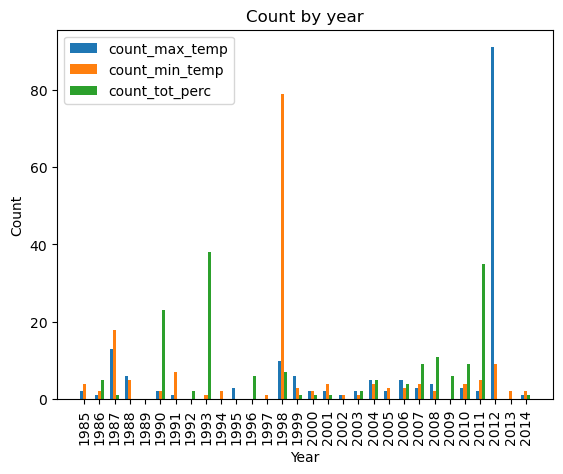

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# temp = answer3['filename','highest_annual_avg_max_temp']
temp =pd.read_csv(des_path+'YearHistogram.out', sep='\t', header=None)
year = temp[0]
count_max_temp = temp[1]
count_min_temp = temp[2]
count_tot_perc = temp[3]


data = {
    "count_max_temp": count_max_temp,
    "count_min_temp": count_min_temp,
    "count_tot_perc": count_tot_perc,
}

fig, ax = plt.subplots()
ax.set_ylabel('Count')
ax.set_xlabel('Year')
ax.set_title('Count by year')

bar_plot(ax, data, total_width=.6, single_width=1)
plt.xticks(range(len(year)),year, rotation='vertical')
plt.show()



In [25]:
# Question 4 - Approach and Analysis
# 1. For each weather station, calculate the correlation (default = Pearson) by matching the records by year
# 2. Write the output to the file
# 2. Concatenate the dataframe
# 3. Apply pivot table with row as year, column as label and value as the count( or size)
# 4. Write the output to the file

In [26]:
input4 = answer2.replace(-9999,np.nan)
yld_src_path = '/Users/arunachalamev/Downloads/DataSciTest/yld_data/'
yld_file = 'US_corn_grain_yield.txt'
yld_data = pd.read_csv(yld_src_path+yld_file, sep='\t', header=None)

In [27]:
input4

,file_name,year,avg_max_temp,avg_min_temp,tot_percipitation
0,USC00110072.txt,1985,15.33,4.33,78.01
1,USC00110072.txt,1986,12.70,2.18,50.53
2,USC00110072.txt,1987,17.76,6.33,79.36
3,USC00110072.txt,1988,17.35,4.53,54.10
4,USC00110072.txt,1989,15.65,3.98,79.37
...,...,...,...,...,...
5005,USC00339312.txt,2010,16.17,4.33,103.40
5006,USC00339312.txt,2011,16.31,5.05,136.07
5007,USC00339312.txt,2012,17.80,5.17,91.08
5008,USC00339312.txt,2013,15.47,4.02,109.90


In [28]:
# yield data column 0 - year and column 1 - yield
yld_data = yld_data.sort_values(by=[0])
temp = []
for file in sorted(wx_data_files):
    temp_df = input4[input4['file_name']==file].sort_values(by=['file_name','year']).reset_index(drop= True)
    
#     print (file, temp_df.shape, yld_data.shape)
    # coorelation calculation ignores NaN's - 
    # Reference :https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
    # [ in Q2 Average calculation ignores missing value, so im assuming the same here]?
    # Calculate the correlation between columns by matching the years ( achieved using sort)
    cor1 = temp_df['avg_max_temp'].corr(yld_data[1])
    cor2 = temp_df['avg_min_temp'].corr(yld_data[1])
    cor3 = temp_df['tot_percipitation'].corr(yld_data[1])

    temp.append([file,cor1,cor2,cor3])

answer4 = pd.DataFrame(temp)

In [29]:
answer4.round(2)

,0,1,2,3
0,USC00110072.txt,-0.27,-0.29,0.21
1,USC00110187.txt,0.28,0.11,0.02
2,USC00110338.txt,-0.30,0.22,0.25
3,USC00111280.txt,-0.25,-0.33,-0.13
4,USC00111436.txt,0.10,0.01,0.09
...,...,...,...,...
162,USC00338552.txt,-0.09,0.08,0.02
163,USC00338769.txt,-0.26,-0.23,0.32
164,USC00338822.txt,-0.37,-0.37,0.26
165,USC00338830.txt,-0.27,0.29,0.18


In [30]:
answer4.isnull().sum()
answer4.to_csv(des_path+'Correlations.out',sep='\t', header=None, index= False,  float_format='%.2f')